In [1]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")   # type: ignore

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PYG_GRAPHS = torch.load("data/processed/pyg_graphs_384D.pt", weights_only=False)

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8


In [2]:
## HELPER FUNCTIONS FOR CREATING AND TRAINING MODEL
import importlib
import src.models.multitask_debate_gnn
importlib.reload(src.models.multitask_debate_gnn)

from src.models.multitask_debate_gnn import ECCConv, MultitaskDebateGNN, train_gnn_live, plot_cv_losses
from torch_geometric.nn import GCNConv, SAGEConv

from typing import Dict, Any, Type, Optional

def create_and_describe_model(model_args: Dict[str, Any], model_class: Type[MultitaskDebateGNN] = MultitaskDebateGNN) -> Optional[MultitaskDebateGNN]:
    """Build the model from args, print a summary, and return the instance (or None on failure)."""
    try:
        model = model_class(**model_args)
        print("Model created:")
        print(f"   Architecture: {[type(conv).__name__ for conv in model.convs]}")
        print(f"   Mode: {model.mode}")
        print(f"   Input dim: {model_args['in_dim']}")
        print(f"   Hidden dim: {model_args['hidden_dim']}")
        print(f"   Embedding dim: {model_args['emb_dim']}")
        print(f"   Number of layers: {model_args['num_layers']}")

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print("\nModel Statistics:")
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")
        print(f"   Model size: ~{total_params * 4 / 1024**2:.1f} MB")

        # Show model structure
        print("\nModel Structure:")
        print(model)
        return model

    except Exception as e:
        print(f"Error creating model: {e}")
        import traceback
        traceback.print_exc()
        return None
    
def run_cv_training(
    graph_data,
    model_args: dict,
    train_args: dict,
    model_class: Type[MultitaskDebateGNN] = MultitaskDebateGNN,
    live_plot: bool = False,):
    """
    Runs cross-validation training with cleanup and plotting.
    Returns (model, results, cv_history) or (None, None, None) on failure.
    """
    import gc, traceback
    import torch

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    try:
        model, results, cv_history = train_gnn_live(
            all_graphs=getattr(graph_data, "pyg_graphs", graph_data),
            model_args=model_args,
            train_args=train_args,
            model_class=model_class,
            live_plot=live_plot,
        )
        plot_cv_losses(cv_history=cv_history)
        return model, results, cv_history
    except Exception as e:
        print(f"Training error: {e}")
        traceback.print_exc()
        return None, None, None

In [3]:
# BASE MODEL AND TRAINING ARGS (shared across all variants)
BASE_MODEL_ARGS = dict(
    in_dim = 384,
    hidden_dim = 256,
    emb_dim = 128,
    neg_attr_weight = 0.3,
    dropout = 0.15,
)

ECC_KWARGS = dict(
    edge_mlp_dropout = 0.1,
    keep_prob = 0.8,
    conf_dim = 1,
    stance_dim = 3
)

BASE_TRAIN_ARGS = dict(
    epochs = 30,
    lr = 0.001,
    patience = 6,
    min_delta = 3e-4,
    neg_sample_ratio = 0.5,
    temp_reg_weight = 0.1,
    val_n_last = 1, # or val_pct_last = 0.25 (pick either one)
    val_gap_n = 1,
)

# To store cv results later
TRAIN_RESULTS = {
    "3-GCN": None,
    "3-SAGE": None,
    "2-SAGE-1-ECC": None,
}
TRAINED_MODELS = {
    "3-GCN": None,
    "3-SAGE": None,
    "2-SAGE-1-ECC": None,
}

In [4]:
# DEFINE VARIANTS ARGS

# 1. 3-GCN -> Link Only
# Take base args for link only
_3gcn_margs = BASE_MODEL_ARGS | dict(
    num_layers=3,
    mode="link_only",
    conv_cls=GCNConv
)

# 2. 3-SAGE -> Link Only
# Take base args for linky only
_3sage_margs = BASE_MODEL_ARGS | dict(
    num_layers=3,
    mode="link_only",
    conv_cls=SAGEConv
)

# 3. 2-SAGE-1-ECC -> Full
_2sage_1ecc_F_margs = BASE_MODEL_ARGS | dict(
    num_layers=3,
    mode="full",
    conv_cls_list=[SAGEConv, SAGEConv, ECCConv],
    ecc_kwargs=ECC_KWARGS   # Share ECC args for all with ECC layer
)

### **3-GCN** (Link Only)

Training 3-GCN...

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: link_only
  - Task weights: Default (1.0 each)
  - Tasks: Link
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,084 nodes | 938 edges | Avg: 93.8 edges/graph
   + Stance Dist: [0.322, 0.239, 0.439] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,291 nodes | 4,297 edges | Avg: 165.3 edges/graph
   + Stance Dist: [0.407, 0.283, 0.310] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 7,302 nodes | 8,143 edges | Avg: 904.8 edges/graph
   + Stance Dist: [0.360, 0.216, 0.424] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,417 nodes | 7,598 edges | Avg: 844.2 edges/graph
   + Stance Dist: [0.401, 0.246, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,380
  - Total edges: 35,556
  - Avg nodes/graph: 316.6
  - Avg edges/graph: 4

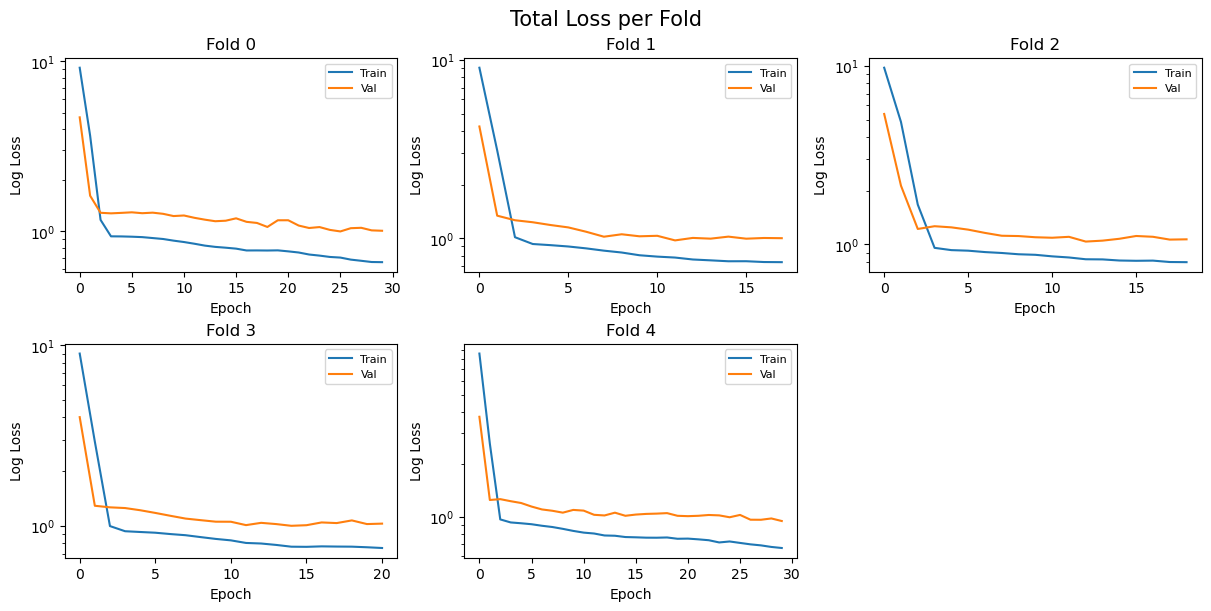

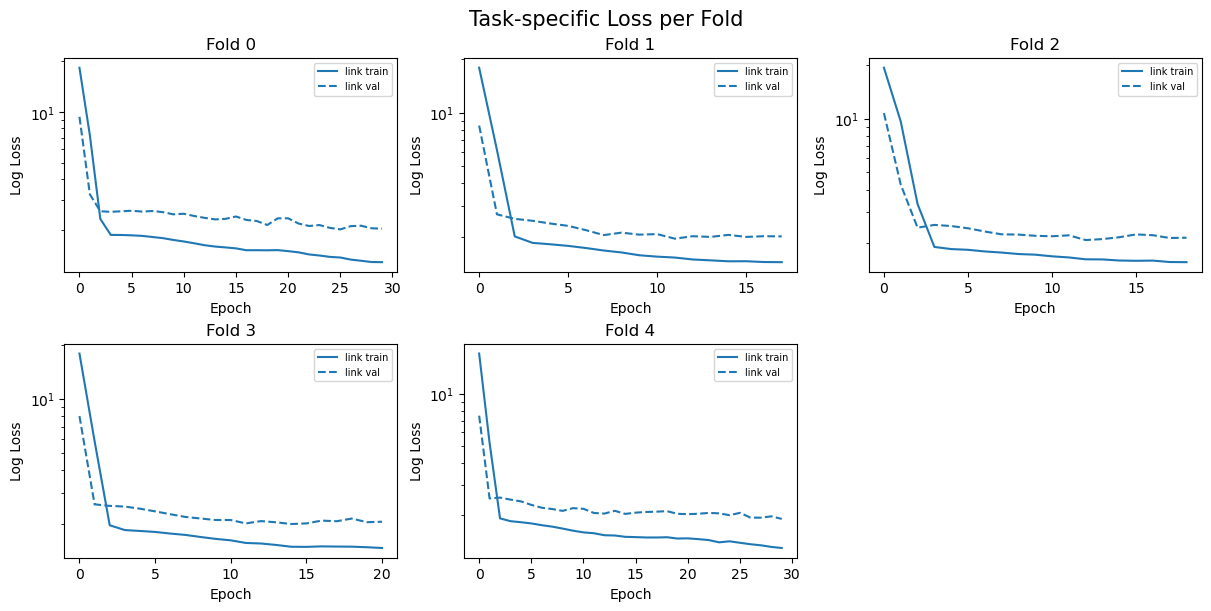

In [5]:
print("Training 3-GCN...")

_3gcn_model, _3gcn_results, _3gcn_cv_history = run_cv_training(
    graph_data = PYG_GRAPHS,
    model_args = _3gcn_margs,
    train_args = BASE_TRAIN_ARGS,
    model_class = MultitaskDebateGNN,
    live_plot = False
)
# Save trained model and result to dict
TRAIN_RESULTS['3-GCN'] = _3gcn_results
TRAINED_MODELS['3-GCN'] = _3gcn_model

### **3-SAGE** (Link Only)

Training 3-SAGE...

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: link_only
  - Task weights: Default (1.0 each)
  - Tasks: Link
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,084 nodes | 938 edges | Avg: 93.8 edges/graph
   + Stance Dist: [0.322, 0.239, 0.439] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,291 nodes | 4,297 edges | Avg: 165.3 edges/graph
   + Stance Dist: [0.407, 0.283, 0.310] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 7,302 nodes | 8,143 edges | Avg: 904.8 edges/graph
   + Stance Dist: [0.360, 0.216, 0.424] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,417 nodes | 7,598 edges | Avg: 844.2 edges/graph
   + Stance Dist: [0.401, 0.246, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,380
  - Total edges: 35,556
  - Avg nodes/graph: 316.6
  - Avg edges/graph: 

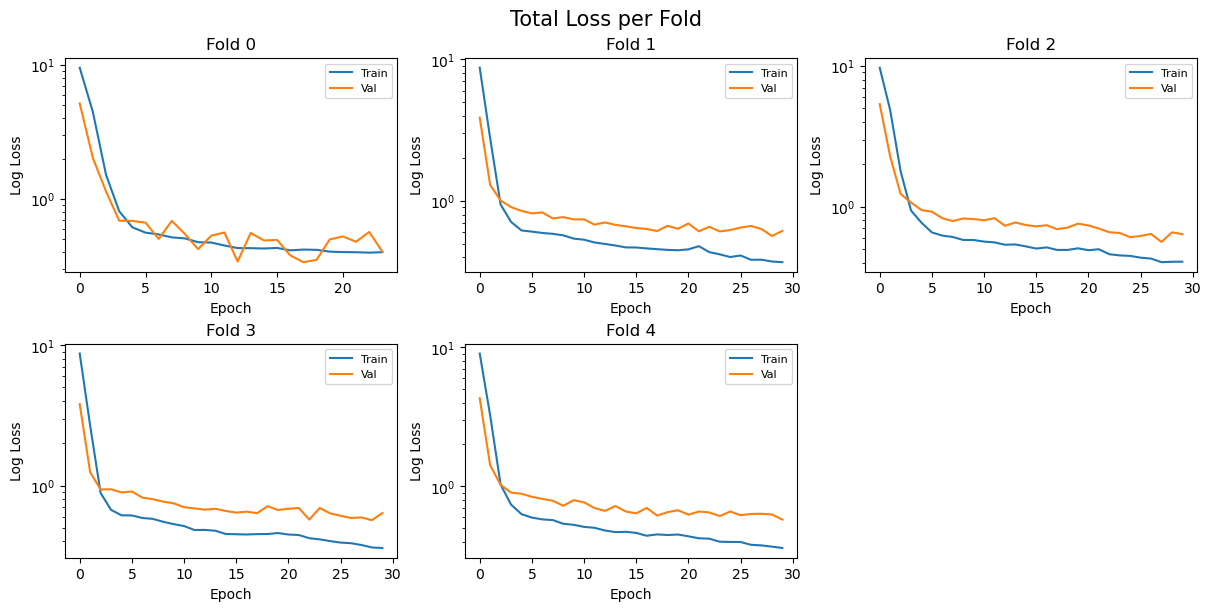

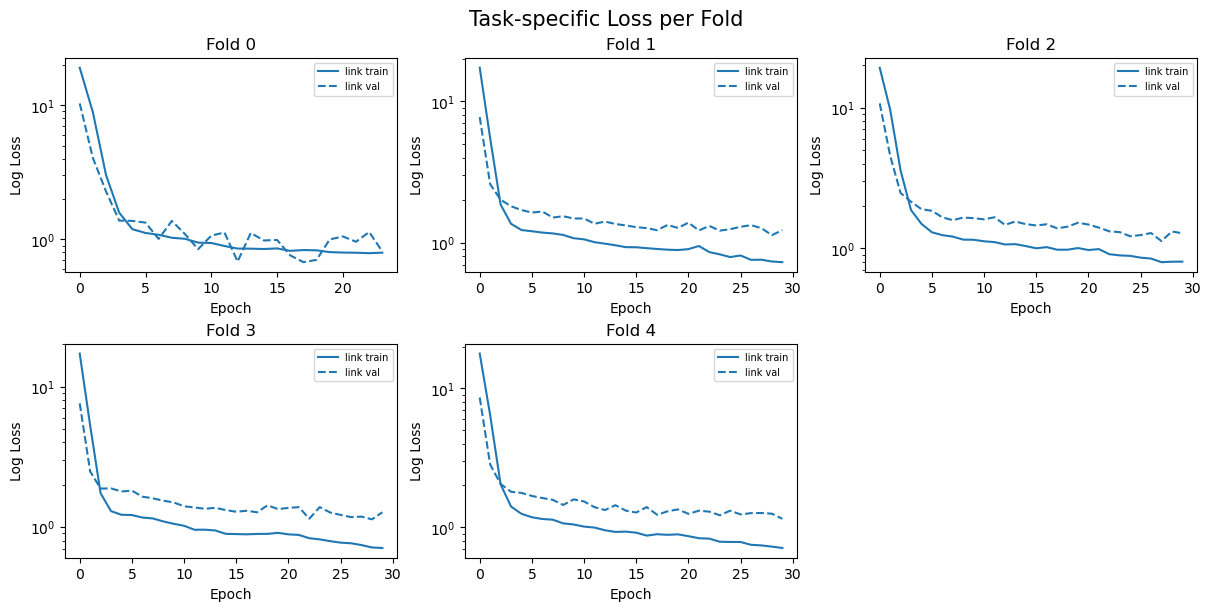

In [6]:
print("Training 3-SAGE...")
_3sage_model, _3sage_results, _3sage_cv_history = run_cv_training(
    graph_data = PYG_GRAPHS,
    model_args = _3sage_margs,
    train_args = BASE_TRAIN_ARGS,
    model_class = MultitaskDebateGNN,
    live_plot = False
)
# Save trained model and result to dict
TRAIN_RESULTS['3-SAGE'] = _3sage_results
TRAINED_MODELS['3-SAGE'] = _3sage_model

### **2-SAGE-1-ECC** (Full)

Training 2-SAGE-1-ECC (Full)...

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: full
  - Task weights: {'link': 1.0, 'conf': 1.0, 'stance': 1.0}
  - Tasks: Link, Confidence, Stance
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,084 nodes | 938 edges | Avg: 93.8 edges/graph
   + Stance Dist: [0.322, 0.239, 0.439] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,291 nodes | 4,297 edges | Avg: 165.3 edges/graph
   + Stance Dist: [0.407, 0.283, 0.310] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 7,302 nodes | 8,143 edges | Avg: 904.8 edges/graph
   + Stance Dist: [0.360, 0.216, 0.424] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,417 nodes | 7,598 edges | Avg: 844.2 edges/graph
   + Stance Dist: [0.401, 0.246, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,380
  - Total edges: 35,5

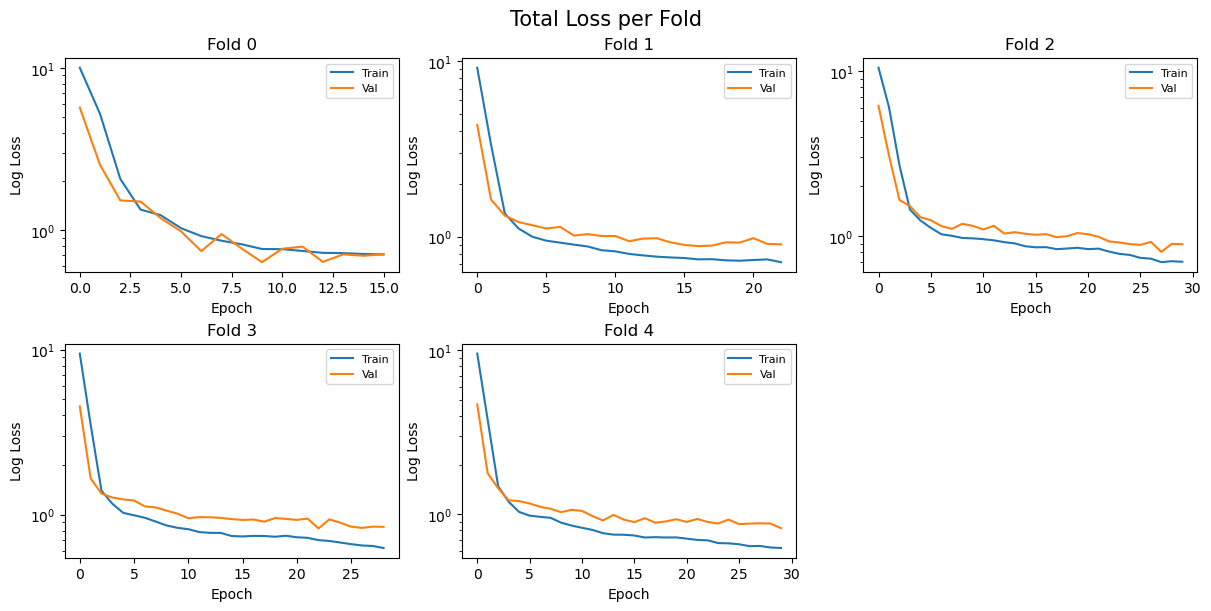

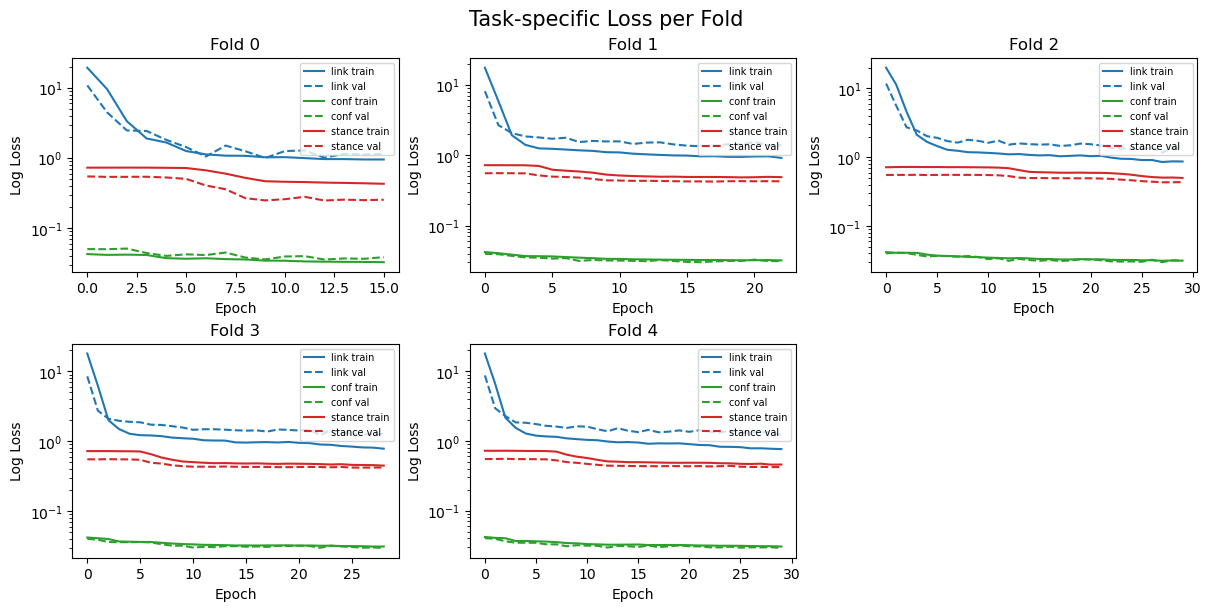

In [7]:
print("Training 2-SAGE-1-ECC (Full)...")
_2sage_1ecc_F_model, _2sage_1ecc_F_results, _2sage_1ecc_F_cv_history = run_cv_training(
    graph_data = PYG_GRAPHS,
    model_args = _2sage_1ecc_F_margs,
    train_args = BASE_TRAIN_ARGS | dict(
        task_weights = {"link": 1.0, "conf": 1.0, "stance": 1.0}
    ),
    model_class = MultitaskDebateGNN,
    live_plot = False
)
# Save trained model and result to dict
TRAIN_RESULTS['2-SAGE-1-ECC'] = _2sage_1ecc_F_results
TRAINED_MODELS['2-SAGE-1-ECC'] = _2sage_1ecc_F_model

### **FINAL RESULTS**

In [8]:
import pandas as pd

records = []
for variant, fold_dict in TRAIN_RESULTS.items():
    for fold_id, metrics in fold_dict.items():
        rec = {"variant": variant, "fold": fold_id}
        rec.update(metrics)
        records.append(rec)

df = pd.DataFrame.from_records(records)
wide = (df.pivot(index="fold", columns="variant").sort_index())
wide.loc["MEAN"] = wide.mean()
wide = wide.round(3)
wide

link_auc                   conf_mae                  conf_nll  \
variant 2-SAGE-1-ECC  3-GCN 3-SAGE 2-SAGE-1-ECC 3-GCN 3-SAGE 2-SAGE-1-ECC   
fold                                                                        
0              0.696  0.709  0.729        0.301   NaN    NaN        0.766   
1              0.891  0.758  0.929        0.343   NaN    NaN        0.697   
2              0.893  0.717  0.910        0.347   NaN    NaN        0.722   
3              0.913  0.789  0.926        0.350   NaN    NaN        0.700   
4              0.916  0.838  0.922        0.340   NaN    NaN        0.725   
MEAN           0.862  0.762  0.883        0.336   NaN    NaN        0.722   

                       stance_nll                 stance_kl               
variant 3-GCN 3-SAGE 2-SAGE-1-ECC 3-GCN 3-SAGE 2-SAGE-1-ECC 3-GCN 3-SAGE  
fold                                                                      
0         NaN    NaN        0.880   NaN    NaN        0.850   NaN    NaN  
1         NaN    NaN        0.435   NaN    NaN        0.430   NaN    NaN  
2         NaN    NaN        0.553   NaN    NaN        0.551   NaN    NaN  
3         NaN    NaN        0.587   NaN    NaN        0.584   NaN    NaN  
4         NaN    NaN        0.560   NaN    NaN        0.558   NaN    NaN  
MEAN      NaN    NaN        0.603   NaN    NaN        0.595   NaN    NaN

In [9]:
df_mean = df.drop(columns="fold").groupby("variant").mean(numeric_only=True).round(3)
df_mean

,link_auc,conf_mae,conf_nll,stance_nll,stance_kl
variant,,,,,
2-SAGE-1-ECC,0.862,0.336,0.722,0.603,0.595
3-GCN,0.762,NaN,NaN,NaN,NaN
3-SAGE,0.883,NaN,NaN,NaN,NaN


In [10]:
# Save df_mean to results/ablation/benchmark_baseline_link_auc.csv
import os

# Create directory if it doesn't exist
os.makedirs("results/ablation", exist_ok=True)
df_mean.to_csv("results/ablation/benchmark_baseline_link_auc.csv")
print("Results saved to results/ablation/benchmark_baseline_link_auc.csv")

Results saved to results/ablation/benchmark_baseline_link_auc.csv
